In [1]:
import argparse
import json
import ssl
import datetime
import os
import math

import numpy as np
import matplotlib.pyplot as plt


from data import get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels, get_eval_dataset
from train import SiameseModel
from metrics import get_kernel_mask, val, far, pairwise_accuracy

import tensorflow as tf
from tensorflow.keras import optimizers

In [9]:
from importlib import reload
reload(data)

<module 'data' from '/Users/deepakduggirala/My Drive/edu/IUB/courses/semester-2/CV/project/siamese/data.py'>

In [2]:
 with open('hyperparameters/initial_run.json', 'rb') as f:
        params = json.load(f)

In [3]:
siamese_model = SiameseModel(params, True)
siamese_model.load_weights('/Users/deepakduggirala/Downloads/best_weights')

In [5]:
data_dir='/Users/deepakduggirala/Documents/ELPephant-cropped'
images, labels = get_eval_dataset(get_ELEP_images_and_labels, params, data_dir)

In [6]:
embeddings = siamese_model.predict(images)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=1)

2022-04-21 23:13:15.579431: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
d=0.25
kernel, mask = get_kernel_mask(labels, embeddings)
print('Validation rate (VAL): ', val(kernel, mask, d))
print('False accept rate (FAR): ', far(kernel, mask, d))
print('pairwise_accuracy: ', pairwise_accuracy(kernel, mask, d))

Validation rate (VAL):  0.6532498933295406
False accept rate (FAR):  0.007985936386984622
11704 4250316
pairwise_accuracy:  0.9903498274680206


In [17]:
data_dir='/Users/deepakduggirala/Documents/Elephants-dataset-cropped-png-1024'
images, labels = get_eval_dataset(get_zoo_elephants_images_and_labels, params, data_dir)
labels.shape

(1691,)

In [18]:
embeddings = siamese_model.predict(images)
embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=1)

In [27]:
d=0.25
kernel, mask = get_kernel_mask(labels, embeddings)
print('Validation rate (VAL): ', val(kernel, mask, d))
print('False accept rate (FAR): ', far(kernel, mask, d))
print('pairwise_accuracy: ', pairwise_accuracy(kernel, mask, d))

Validation rate (VAL):  0.15159076731129134
False accept rate (FAR):  0.014974935986517031
25768 2638234
pairwise_accuracy:  0.9321895590648718


In [28]:
embeddings.shape

(1691, 256)

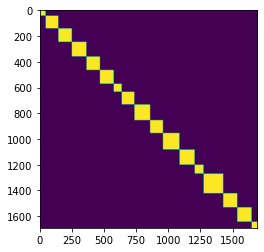

In [25]:
plt.imshow(mask)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=50, init='random').fit_transform(embeddings)

In [ ]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

# for i, label in enumerate(pts):
#     plt.annotate(label, (X_embedded[i,0], X_embedded[i,1]))




In [ ]:
# R = np.random.randint(low=0, high=2, size=(N,N)).astype(np.bool8)
# TP = np.sum(mask * R)
# TN = np.sum(~mask * R)
# (TP+TN)/(N*(N))

In [347]:
# d = 0.5
# p_same_idx = np.triu_indices(7, k = 1)
# N = p_same_idx[0].shape[0]
# np.sum(K[:7,:7][p_same_idx] < d)/N

In [342]:
# N = categories.shape[0]
# Z = np.zeros((N, N, 3), dtype=np.int32)
# X, Y = np.meshgrid(np.arange(N), np.arange(N))
# Z[:,:,0] = Y
# Z[:,:,1] = X
# Z[:,:, 2] = mask
# ix, iy = np.triu_indices(N, k = 1)

# tr_u = Z[ix, iy, :]

# same_idx = tr_u[tr_u[:,2]==1, :2]
# diff_idx = tr_u[tr_u[:,2]==0, :2]

In [296]:
# same_idx

In [293]:
# TA = K[same_idx[:,0], same_idx[:,1]] < d

# VAL = np.sum(TA)/TA.shape[0]
# VAL

In [294]:
# np.sum(TA), TA.shape[0]

In [295]:
# FA = K[diff_idx[:,0], diff_idx[:,1]] <= d

# FAR = np.sum(FA)/FA.shape[0]
# FAR

In [297]:
# np.sum(FA), FA.shape